## Dimensionality reduction

### The curse of dimensionality

TODO: text

### Principal Component Analysis

In the following example a distribution of points drawn from a bivariate Gaussian and centered on the
origin of $x$ and $y$. 
PCA defines a rotation such that the new axes ($x’$ and $y’$) are aligned along the directions of maximal 
variance (the principal components) with zero covariance. This is equivalent to minimizing the square of 
the perpendicular distances between the points and the principal components.

In [64]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.patches import Ellipse
from matplotlib import ticker

In [2]:
np.random.seed(42)
r = 0.9

sigma1 = 0.25
sigma2 = 0.08
rotation = np.pi / 6
s = np.sin(rotation)
c = np.cos(rotation)

X = np.random.normal(0, [sigma1, sigma2], size=(100, 2)).T
R = np.array([[c, -s],
              [s, c]])
X = np.dot(R, X)

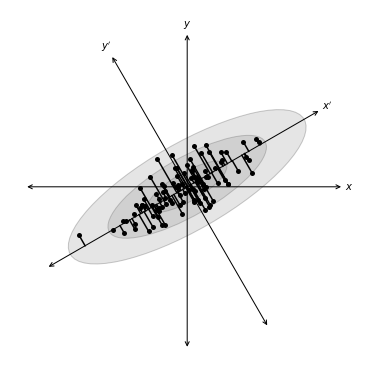

In [3]:
#------------------------------------------------------------
# Plot the diagram
fig = plt.figure(figsize=(5, 5), facecolor='w')
ax = plt.axes((0, 0, 1, 1), xticks=[], yticks=[], frameon=False)

# draw axes
ax.annotate(r'$x$', (-r, 0), (r, 0),
            ha='center', va='center',
            arrowprops=dict(arrowstyle='<->', color='k', lw=1))
ax.annotate(r'$y$', (0, -r), (0, r),
            ha='center', va='center',
            arrowprops=dict(arrowstyle='<->', color='k', lw=1))

# draw rotated axes
ax.annotate(r'$x^\prime$', (-r * c, -r * s), (r * c, r * s),
            ha='center', va='center',
            arrowprops=dict(color='k', arrowstyle='<->', lw=1))
ax.annotate(r'$y^\prime$', (r * s, -r * c), (-r * s, r * c),
            ha='center', va='center',
            arrowprops=dict(color='k', arrowstyle='<->', lw=1))

# scatter points
ax.scatter(X[0], X[1], s=25, lw=0, c='k', zorder=2)

# draw lines
vnorm = np.array([s, -c])
for v in (X.T):
    d = np.dot(v, vnorm)
    v1 = v - d * vnorm
    ax.plot([v[0], v1[0]], [v[1], v1[1]], '-k')

# draw ellipses
for sigma in (1, 2, 3):
    ax.add_patch(Ellipse((0, 0), 2 * sigma * sigma1, 2 * sigma * sigma2,
                         rotation * 180. / np.pi,
                         ec='k', fc='gray', alpha=0.2, zorder=1))

ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)

plt.show()

#### Application of PCA

In the following example we have 100 data points in 3 dimensions, $X$, and $R$ as the projection matrix. To compute the PCA components (4 in our case) we use `PCA` from `scikit-learn`. 

In [50]:
from sklearn.decomposition import PCA

X = np.random.normal(size=(100, 3))
R = np.random.random((3, 10))
X = np.dot(X, R)

pca = PCA(n_components=4)
pca.fit(X)
comp = pca.transform(X)

mean = pca.mean_
components = pca.components_
var = pca.explained_variance_


For our astronomy use case, we are using the SDSS spectroscopic dataset. 
The SDSS spectra come from galaxies at a range of redshifts,
and have sections of unreliable or missing data due to sky absorption, cosmic rays, bad detector pixels,
or other effects. AstroML provides a set of spectra which have been moved to rest frame, corrected
for masking using an iterative PCA reconstruction technique, and resampled to 1000 common wavelength bins. 

The spectra can be downloaded using `fetch_sdss_corrected_spectra()`. In the following example we plot
15 of these spectra:

In [75]:
import numpy as np
from matplotlib import pyplot as plt
from astroML.datasets import sdss_corrected_spectra

#----------------------------------------------------------------------
# Use pre-computed PCA to reconstruct spectra
data = sdss_corrected_spectra.fetch_sdss_corrected_spectra()
spectra_raw = data['spectra']
spectra_corr = sdss_corrected_spectra.reconstruct_spectra(data)
wavelengths = sdss_corrected_spectra.compute_wavelengths(data)

#------------------------------------------------------------
# select random spectra
np.random.seed(5)
nrows = 5
ncols = 3
ind = np.random.randint(spectra.shape[0], size=nrows * ncols)
spec_sample_raw = spectra_raw[ind]
spec_sample_corr = spectra_corr[ind]

We show the SDSS downloaded spectra with black, and our corrected spectra with blue.

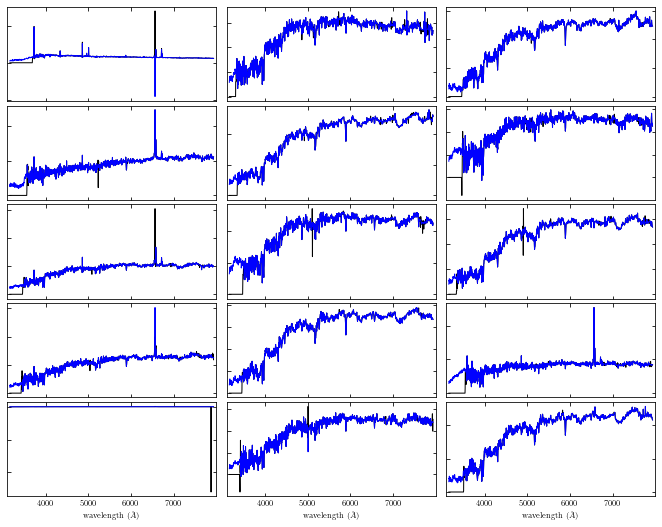

In [39]:
fig = plt.figure(figsize=(10, 8))

fig.subplots_adjust(left=0.05, right=0.95, wspace=0.05,
                    bottom=0.1, top=0.95, hspace=0.05)

for i in range(ncols):
    for j in range(nrows):
        ax = fig.add_subplot(nrows, ncols, ncols * j + 1 + i)
        ax.plot(wavelengths, spec_sample_raw[ncols * j + i], '-k', lw=1)
        ax.plot(wavelengths, spec_sample_corr[ncols * j + i], '-k', lw=1, c='blue')               
        ax.set_xlim(3100, 7999)

        ax.yaxis.set_major_formatter(plt.NullFormatter())
        ax.xaxis.set_major_locator(plt.MultipleLocator(1000))
        if j < nrows - 1:
            ax.xaxis.set_major_formatter(plt.NullFormatter())
        else:
            plt.xlabel(r'wavelength $(\AA)$')

        ylim = ax.get_ylim()
        dy = 0.05 * (ylim[1] - ylim[0])
        ax.set_ylim(ylim[0] - dy, ylim[1] + dy)

plt.show()

### PCA Reconstruction of a spectrum

We can reconstruction of a particular spectrum from its eigenvectors. The input spectrum is shown in gray,
and the partial reconstruction for progressively more terms is shown in black. 
The top panel shows only the mean of the set of spectra. By the time 20 PCA components are added,
the reconstruction is very close to the input, as indicated by the expected total variance of 94%.

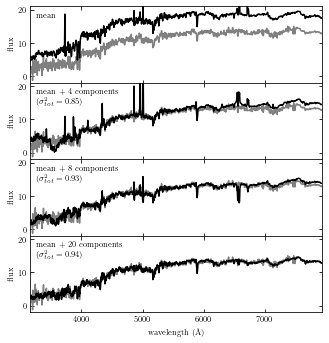

In [45]:
#------------------------------------------------------------
# Compute PCA components

# Eigenvalues can be computed using PCA as in the commented code below:

#from sklearn.decomposition import PCA
#pca = PCA()
#pca.fit(spectra_corr)
#evals = pca.explained_variance_ratio_
#evals_cs = evals.cumsum()

#  because the spectra have been reconstructed from masked values, this
#  is not exactly correct in this case: we'll use the values computed
#  in the file compute_sdss_pca.py
evals = data['evals'] ** 2
evals_cs = evals.cumsum()
evals_cs /= evals_cs[-1]
evecs = data['evecs']
spec_mean = spectra_corr.mean(0)

#------------------------------------------------------------
# Find the coefficients of a particular spectrum
spec = spectra_corr[1]
coeff = np.dot(evecs, spec - spec_mean)

#------------------------------------------------------------
# Plot the sequence of reconstructions
fig = plt.figure(figsize=(5, 5))
fig.subplots_adjust(hspace=0, top=0.95, bottom=0.1, left=0.12, right=0.93)

for i, n in enumerate([0, 4, 8, 20]):
    ax = fig.add_subplot(411 + i)
    ax.plot(wavelengths, spec, '-', c='gray')
    ax.plot(wavelengths, spec_mean + np.dot(coeff[:n], evecs[:n]), '-k')

    if i < 3:
        ax.xaxis.set_major_formatter(plt.NullFormatter())

    ax.set_ylim(-2, 21)
    ax.set_ylabel('flux')

    if n == 0:
        text = "mean"
    elif n == 1:
        text = "mean + 1 component\n"
        text += r"$(\sigma^2_{tot} = %.2f)$" % evals_cs[n - 1]
    else:
        text = "mean + %i components\n" % n
        text += r"$(\sigma^2_{tot} = %.2f)$" % evals_cs[n - 1]

    ax.text(0.02, 0.93, text, ha='left', va='top', transform=ax.transAxes)

fig.axes[-1].set_xlabel(r'${\rm wavelength\ (\AA)}$')
plt.show()

### Eigenvalues

The eigenvalues for the PCA decomposition of the SDSS spectra described in the previous section. The top panel
shows the decrease in eigenvalue as a function of the number of eigenvectors, with a break in the distribution
at ten eigenvectors. The lower panel shows the cumulative sum of eigenvalues normalized to unity. 
94% of the variance in the SDSS spectra can be captured using the first ten eigenvectors.

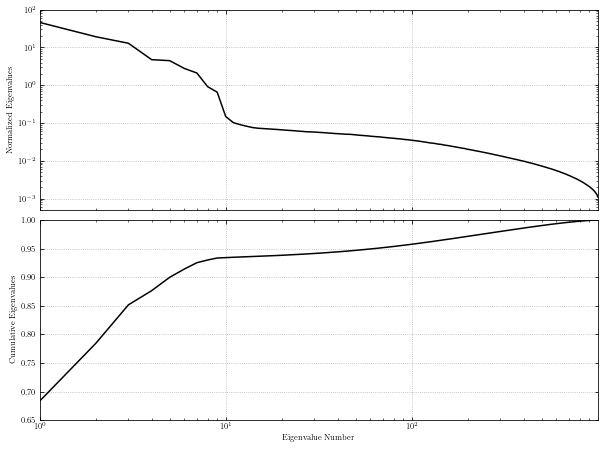

In [47]:
fig = plt.figure(figsize=(10, 7.5))
fig.subplots_adjust(hspace=0.05, bottom=0.12)

ax = fig.add_subplot(211, xscale='log', yscale='log')
ax.grid()
ax.plot(evals, c='k')
ax.set_ylabel('Normalized Eigenvalues')
ax.xaxis.set_major_formatter(plt.NullFormatter())
ax.set_ylim(5E-4, 100)

ax = fig.add_subplot(212, xscale='log')
ax.grid()
ax.semilogx(evals_cs, color='k')
ax.set_xlabel('Eigenvalue Number')
ax.set_ylabel('Cumulative Eigenvalues')
ax.set_ylim(0.65, 1.00)

plt.show()

### PCA with missing data

The principal component vectors defined for the SDSS spectra can be used to interpolate across or reconstruct
missing data. Examples of three masked spectral regions are shown comparing the reconstruction of the input 
spectrum (black line) using the mean and the first ten eigenspectra (blue line) The gray bands represent the 
masked region of the spectrum.

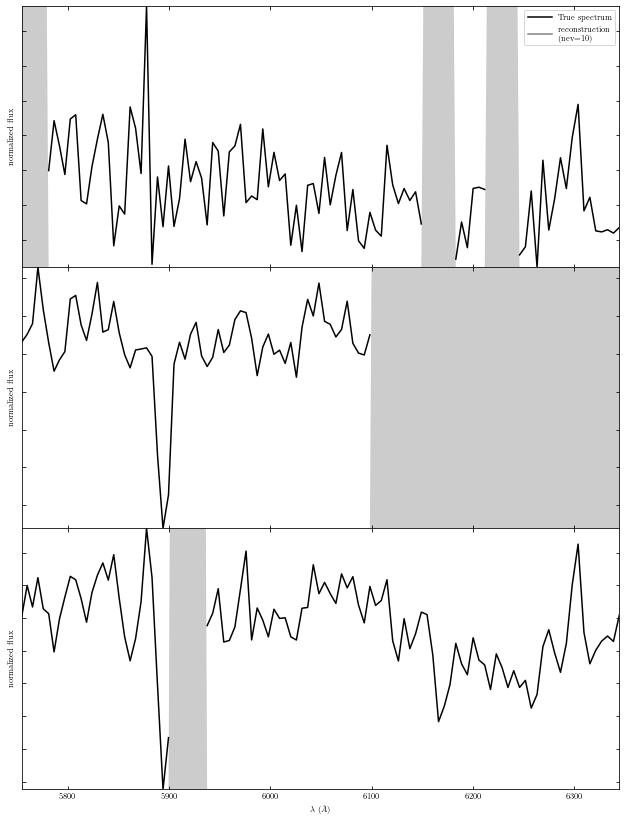

In [68]:
evecs = data['evecs']
mu = data['mu']
norms = data['norms']
mask = data['mask']

#------------------------------------------------------------
# plot the results
i_plot = ((wavelengths > 5750) & (wavelengths < 6350))
wavelength = wavelengths[i_plot]

specnums = [20, 8, 9]
subplots = [311, 312, 313]

fig = plt.figure(figsize=(10, 12.5))
fig.subplots_adjust(left=0.09, bottom=0.08, hspace=0, right=0.92, top=0.95)

for subplot, i in zip(subplots, specnums):
    ax = fig.add_subplot(subplot)

    # compute eigen-coefficients
    spectra_i_centered = spectra_corr[i] / norms[i] - mu
    coeffs = np.dot(spectra_i_centered, evecs.T)

    # blank out masked regions
    spectra_i = spectra_corr[i]
    mask_i = mask[i]
    spectra_i[mask_i] = np.nan

    # plot the raw masked spectrum
    ax.plot(wavelength, spectra_i[i_plot], '-', color='k',
            label='True spectrum', lw=1.5)

    # plot two levels of reconstruction
    for nev in [10]:
        if nev == 0:
            label = 'mean'
        else:
            label = 'reconstruction\n(nev=%i)' % nev
        spectra_i_recons = norms[i] * (mu + np.dot(coeffs[:nev], evecs[:nev]))
        ax.plot(wavelength, spectra_i_recons[i_plot], label=label, color='grey')

    # plot shaded background in masked region
    ylim = ax.get_ylim()
    mask_shade = ylim[0] + mask[i][i_plot].astype(float) * ylim[1]
    plt.fill(np.concatenate([lam[:1], lam, lam[-1:]]),
             np.concatenate([[ylim[0]], mask_shade, [ylim[0]]]),
             lw=0, fc='k', alpha=0.2)

    ax.set_xlim(lam[0], lam[-1])
    ax.set_ylim(ylim)
    ax.yaxis.set_major_formatter(ticker.NullFormatter())

    if subplot == 311:
        ax.legend(loc=1)

    ax.set_xlabel('$\lambda\ (\AA)$')
    ax.set_ylabel('normalized flux')

plt.show()

### Nonnegative Matrix Factorization

In [70]:
from sklearn.decomposition import NMF

X = np.random.random((100, 3))  # 100 points in 3 dims, all positive
nmf = NMF(n_components=3)  # setting n_components is optional
nmf.fit(X)
proj = nmf.transform(X)  # project to 3 dimensions

comp = nmf.components_  # 3 x 10 array of components
err = nmf.reconstruction_err_  # how well 3 components captures data


/Users/bsipocz/.pyenv/versions/3.9.1/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


### Independent component analysis

In [72]:
from sklearn.decomposition import FastICA

X = np.random.normal(size=(100, 2))  # 100 pts in 2 dims
R = np.random.random((2, 5))  # mixing matrix
X = np.dot(X, R)  # X is now 2D data in 5D space
ica = FastICA(2)  # fit two components

sources = ica.fit_transform(X)
proj = ica.transform(X)  # 100 x 2 projection of data
comp = ica.components_  # the 2 x 5 matrix of indep. components


### Comparing PCA, NMF and ICA

A comparison of the decomposition of SDSS spectra using PCA (left panel), ICA (middle panel) and 
NMF (right panel). The rank of the component increases from top to bottom. For the ICA and PCA 
the first component is the mean spectrum (NMF does not require mean subtraction). All of these 
techniques isolate a common set of spectral features (identifying features associated with the 
continuum and line emission). The ordering of the spectral components is technique dependent.

/Users/bsipocz/.pyenv/versions/3.9.1/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "
/Users/bsipocz/.pyenv/versions/3.9.1/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


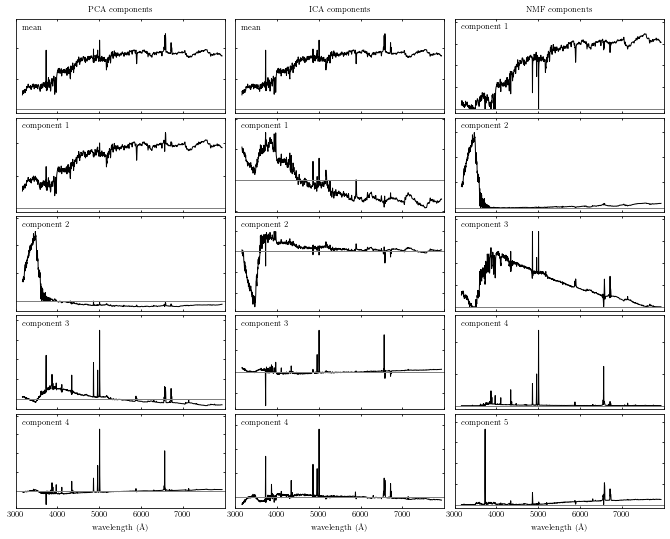

In [77]:
from sklearn.decomposition import NMF, FastICA, PCA

spectra = spectra_corr
#----------------------------------------------------------------------
# Compute PCA, ICA, and NMF components
def compute_PCA_ICA_NMF(n_components=5):
    spec_mean = spectra.mean(0)

    # PCA: use randomized PCA for speed
    pca = PCA(n_components - 1, random_state=0, svd_solver='randomized')
    pca.fit(spectra)
    pca_comp = np.vstack([spec_mean,
                          pca.components_])

    # ICA treats sequential observations as related.  Because of this, we need
    # to fit with the transpose of the spectra
    ica = FastICA(n_components - 1, random_state=0)
    ica.fit(spectra.T)
    ica_comp = np.vstack([spec_mean,
                          ica.transform(spectra.T).T])

    # NMF requires all elements of the input to be greater than zero
    spectra[spectra < 0] = 0
    nmf = NMF(n_components, random_state=0)
    nmf.fit(spectra)
    nmf_comp = nmf.components_

    return pca_comp, ica_comp, nmf_comp

n_components = 5
decompositions = compute_PCA_ICA_NMF(n_components)

#----------------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(10, 8))
fig.subplots_adjust(left=0.05, right=0.95, wspace=0.05,
                    bottom=0.1, top=0.95, hspace=0.05)

titles = ['PCA components', 'ICA components', 'NMF components']

for i, comp in enumerate(decompositions):
    for j in range(n_components):
        ax = fig.add_subplot(n_components, 3, 3 * j + 1 + i)

        ax.yaxis.set_major_formatter(plt.NullFormatter())
        ax.xaxis.set_major_locator(plt.MultipleLocator(1000))
        if j < n_components - 1:
            ax.xaxis.set_major_formatter(plt.NullFormatter())
        else:
            ax.xaxis.set_major_locator(
                plt.FixedLocator(list(range(3000, 7999, 1000))))
            ax.set_xlabel(r'wavelength ${\rm (\AA)}$')

        ax.plot(wavelengths, comp[j], '-k', lw=1)

        # plot zero line
        xlim = [3000, 8000]
        ax.plot(xlim, [0, 0], '-', c='gray', lw=1)

        if j == 0:
            ax.set_title(titles[i])

        if titles[i].startswith('PCA') or titles[i].startswith('ICA'):
            if j == 0:
                label = 'mean'
            else:
                label = 'component %i' % j
        else:
            label = 'component %i' % (j + 1)

        ax.text(0.03, 0.94, label, transform=ax.transAxes,
                ha='left', va='top')

        for l in ax.get_xticklines() + ax.get_yticklines():
            l.set_markersize(2)

        # adjust y limits
        ylim = plt.ylim()
        dy = 0.05 * (ylim[1] - ylim[0])

        ax.set_ylim(ylim[0] - dy, ylim[1] + 4 * dy)
        ax.set_xlim(xlim)


plt.show()

### Conclusions

TODO: add table 7.1